# Analyse des Datasets

In [1]:
import pandas as pd
import re

# Charger les datasets
matches = pd.read_csv("datasets/matches.csv")
joueurs = pd.read_csv("datasets/joueurs_grands_championnats.csv")

# Afficher les premières lignes
print("Aperçu de matches.csv :")
print(matches.head())

print("\nAperçu de joueurs_grands_championnats.csv :")
print(joueurs.head())

# Vérifier les infos générales
print("\nInfos matches.csv :")
print(matches.info())

print("\nInfos joueurs_grands_championnats.csv :")
print(joueurs.info())
print(joueurs['Date de Naissance'].head())

def extraire_age(date_str):
    match = re.search(r"\((\d+)\)", date_str)  # Recherche du nombre entre parenthèses
    return int(match.group(1)) if match else None  # Retourne l'âge sous forme d'entier

joueurs["Age"] = joueurs["Date de Naissance"].apply(extraire_age)

# Vérifier le résultat
print(joueurs["Age"].head())

Aperçu de matches.csv :
  Journee        Date       Equipe 1  Score 1  Score 2        Equipe 2  \
0       1  2023-08-11        Almeria        0        2  Rayo Vallecano   
1       1  2023-08-11        Sevilla        1        2        Valencia   
2       1  2023-08-12  Real Sociedad        1        1          Girona   
3       1  2023-08-12     Las Palmas        1        1        Mallorca   
4       1  2023-08-12  Athletic Club        0        2     Real Madrid   

  Championnat  Saison            Ville  Temp Max  Temp Min  Precipitations  
0     la-liga    2023          Almería      35.9      26.5             0.0  
1     la-liga    2023          Séville      44.6      24.9             0.0  
2     la-liga    2023  Saint-Sébastien      24.4      17.3             0.5  
3     la-liga    2023       Las Palmas      41.7      26.4             0.0  
4     la-liga    2023           Bilbao      24.5      18.0             2.2  

Aperçu de joueurs_grands_championnats.csv :
  Championnat  Saison   

In [2]:
col_club = "Club"
col_saison = "Saison"
col_age = "Age"
col_valeur = "Valeur Marchande"


from dateutil import parser

joueurs['Date de Naissance'] = joueurs['Date de Naissance'].apply(lambda x: parser.parse(x, dayfirst=True) if pd.notnull(x) else pd.NaT)

print(joueurs['Date de Naissance'].head())
joueurs['Date de Naissance'] = pd.to_datetime(joueurs['Date de Naissance'], format='%d %b %Y', errors='coerce')

print(joueurs['Date de Naissance'].head())

joueurs['annee_naissance'] = joueurs['Date de Naissance'].dt.year


# Calcul de l'âge en fonction de l'année actuelle
joueurs['Age'] = col_saison - joueurs['Date de Naissance'].dt.year
joueurs['Saison'] = joueurs[col_saison].astype(int)

# Maintenant, tu peux regrouper et calculer les moyennes comme tu le souhaites
features_clubs = joueurs.groupby([col_club, col_saison]).agg(
    Age_Moyen=('Age', 'mean'),
    Valeur_Marchande_Moyenne=(col_valeur, 'mean')
).reset_index()

print(features_clubs.head())



ParserError: Unknown string format: 25 févr. 1999 (23)

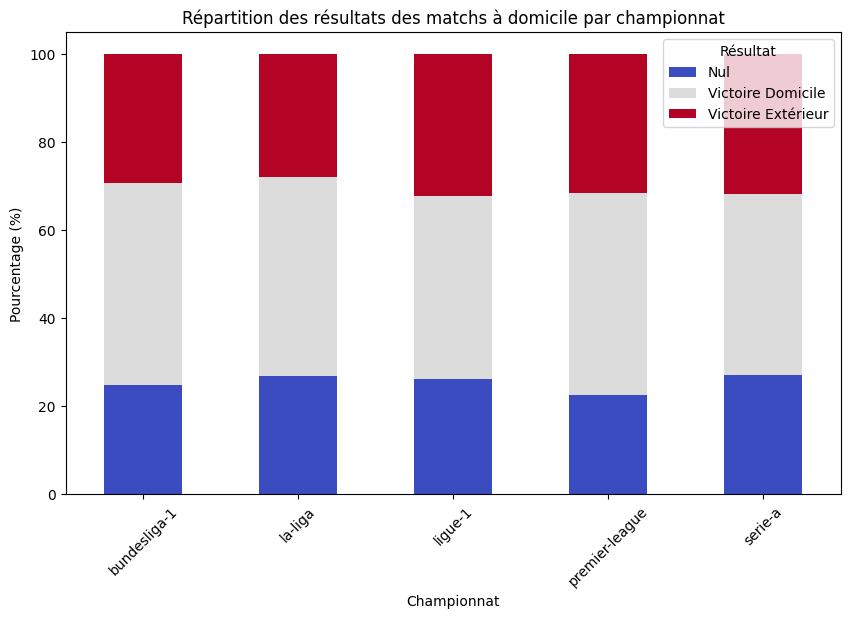

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv("datasets/matches.csv")

# Filtrer les 5 grands championnats
championnats = ["la-liga", "ligue-1", "premier-league", "bundesliga-1", "serie-a"]
df = df[df["Championnat"].isin(championnats)]

# Déterminer le résultat du match
conditions = [
    df["Score 1"] > df["Score 2"],
    df["Score 1"] == df["Score 2"],
    df["Score 1"] < df["Score 2"]
]
choix = ["Victoire Domicile", "Nul", "Victoire Extérieur"]

df["Résultat"] = np.select(conditions, choix)

# Calculer les pourcentages par championnat
resultats = df.groupby(["Championnat", "Résultat"]).size().unstack().apply(lambda x: x / x.sum(), axis=1) * 100

# Affichage des résultats
resultats.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title("Répartition des résultats des matchs à domicile par championnat")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=45)
plt.legend(title="Résultat")
plt.show()


C:\Users\antoi\AppData\Local\Temp\ipykernel_23412\4276955905.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultats = df.groupby(["Catégorie Temp", "Résultat"]).size().unstack().apply(lambda x: x / x.sum(), axis=1) * 100


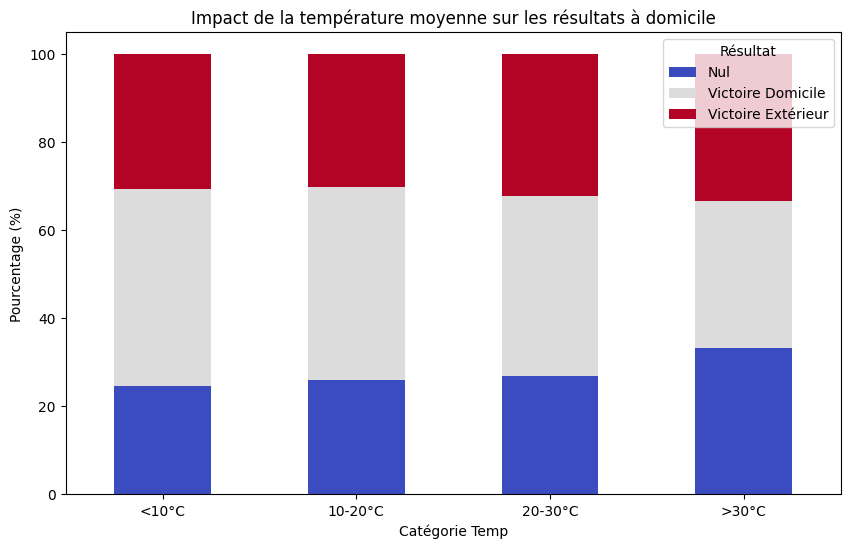

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger le dataset
df = pd.read_csv("datasets/matches.csv")

# Calculer la température moyenne
df["Temp Moyenne"] = (df["Temp Max"] + df["Temp Min"]) / 2

# Définir les intervalles de température
bins = [-np.inf, 10, 20, 30, np.inf]  # Catégories : <10°C, 10-20°C, 20-30°C, >30°C
labels = ["<10°C", "10-20°C", "20-30°C", ">30°C"]
df["Catégorie Temp"] = pd.cut(df["Temp Moyenne"], bins=bins, labels=labels)

# Déterminer le résultat du match
conditions = [
    df["Score 1"] > df["Score 2"],
    df["Score 1"] == df["Score 2"],
    df["Score 1"] < df["Score 2"]
]
choix = ["Victoire Domicile", "Nul", "Victoire Extérieur"]
df["Résultat"] = np.select(conditions, choix)

# Calculer les pourcentages par catégorie de température
resultats = df.groupby(["Catégorie Temp", "Résultat"]).size().unstack().apply(lambda x: x / x.sum(), axis=1) * 100

# Affichage des résultats
resultats.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")
plt.title("Impact de la température moyenne sur les résultats à domicile")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Résultat")
plt.show()
